## Section 1: Preparation
This section configures the environment, imports python modules, defines helper fuctions and calculates additinal data required in preparation for HUI computation.

In [30]:
# IMPORT PYTHON PACKAGES
import numpy as np
import pandas as pd
import math 
from math import pi
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import betainc
import seaborn as sns

# SET-UP PANDAS DISPLAY OPTIONs
pd.set_option('display.max_columns', None)  # None means no limit
pd.set_option('display.max_rows', None) 

In [31]:
# IMPORT DATA
data_complete = pd.read_csv('../Data/large_data.csv')
data_incomplete = pd.read_csv('../Data/exoplanet_data_full.csv')
data = data_complete

# ADD COLUMN FOR MISSING DATA IDENTIFICATION
def add_missing_data_indicator(df):
    df['has_missing_data'] = df.isnull().any(axis=1)
    return df

data = add_missing_data_indicator(data)

In [32]:
# DEFINE HELPER FUNCTIONS
def map_value(value, from_min, from_max, to_min, to_max):
    """
    Maps a value from one range to another.

    Parameters:
    value (float): The value to be mapped.
    from_min (float): The minimum of the original range.
    from_max (float): The maximum of the original range.
    to_min (float): The minimum of the target range.
    to_max (float): The maximum of the target range.

    Returns:
    float: The value mapped to the target range.
    """
    # Calculate the proportion of the value within the original range
    proportion = (value - from_min) / (from_max - from_min)
    
    # Calculate the mapped value in the target range
    mapped_value = to_min + proportion * (to_max - to_min)
    
    return mapped_value

def index_from_min_ideal_max(value, mid_ideal, min_nonideal, max_nonideal, LB, UB, extrema = 0.1):
    """
    Derives an index value from 0-1 for a quantity where both min and max non-ideal values are known.

    Parameters:
    value (float): The value to be mapped.
    mid_ideal (float): The ideal value for given input.
    min_nonideal (float): The min non-ideal value for given input.
    max_nonideal (float): The max non-ideal value for given input.
    LB (float): The lower boundary representing the theoretical acceptable minimum for given input.
    UB (float): The upper boundary representing the theoretical acceptable maximum for given input.
    extrema (float): The maximum index value that can be scored if the input falls out of min non-ideal to max non-ideal range.

    Returns:
    float: The index value obtained from the given input.
    """

    # Guard against NaN
    if (math.isnan(value)):
        return extrema 

    # Case 0: value is ideal -> return 1
    if value == mid_ideal:
        return 1
    
    # Case 1: value is between ideal and max nonideal -> map value from -1 to -lowest score
    if mid_ideal < value < max_nonideal:
        index = 0 - map_value(value, mid_ideal, max_nonideal, -1, -extrema)
        return index
    
    # Case 2: value is between min nonideal and ideal -> map value value from 0.1 to 1
    if min_nonideal < value < mid_ideal:
        index = map_value(value, min_nonideal, mid_ideal, extrema, 1)
        return index
    
    # Case 3: value is between max nonideal and UB -> by definition the tempearture is non-ideal and would have scored 0.1
    #         however as it is past the max value map it to the range 0 -> 0.1 and subtract from 0.1 to get the final result
    if max_nonideal < value < UB:
        decrement = map_value(value, max_nonideal, UB, 0, extrema)
        index = extrema - decrement
        return index
    
    # Case 4: value is between LB and min nonideal -> by definition the value is non-ideal and woudld have scored 0.1
    #         however as it is less than min nonideal map it to the range -0.1 -> 0 and add it to 0.1 to get the final result
    if LB < value < min_nonideal:
        decrement = map_value(value, LB, min_nonideal, -extrema, 0)
        index = extrema + decrement
        return index
    
    return 666

def index_from_min_ideal(value, mid_ideal, min_nonideal, LB, extrema = 0.1):
    """
    Derives an index value from 0-1 for a quantity where only the min non-ideal value is known.

    Parameters:
    value (float): The value to be mapped.
    mid_ideal (float): The ideal value for given input.
    min_nonideal (float): The min non-ideal value for given input.
    LB (float): The lower boundary representing the theoretical acceptable minimum for given input.
    extrema (float): The maximum index value that can be scored if the input falls out of min non-ideal to max non-ideal range.

    Returns:
    float: The index value obtained from the given input. 
    """

    # Guard against NaN
    if (math.isnan(value)):
        return extrema 

    # Case 0: value is ideal -> return 1
    if value == mid_ideal:
        return 1
    
    # Case 1: value is between min nonideal and ideal -> map value value from 0.1 to 1
    if min_nonideal < value < mid_ideal:
        index = map_value(value, min_nonideal, mid_ideal, extrema, 1)
        return index
    
    # Case 2: value is between LB and min nonideal -> by definition the value is non-ideal and woudld have scored 0.1
    #         however as it is less than min nonideal map it to the range -0.1 -> 0 and add it to 0.1 to get the final result
    if LB < value < min_nonideal:
        decrement = map_value(value, LB, min_nonideal, -extrema, 0)
        index = extrema + decrement
        return index
    
    return 666

def index_from_ideal_max(value, mid_ideal, max_nonideal, UB, extrema = 0.1):
    """
    Derives an index value from 0-1 for a quantity where only the max non-ideal value is known.

    Parameters:
    value (float): The value to be mapped.
    mid_ideal (float): The ideal value for given input.
    max_nonideal (float): The max non-ideal value for given input.
    UB (float): The upper boundary representing the theoretical acceptable maximum for given input.
    extrema (float): The maximum index value that can be scored if the input falls out of min non-ideal to max non-ideal range.

    Returns:
    float: The index value obtained from the given input. 
    """

    # Guard against NaN
    if (math.isnan(value)):
        return extrema 

    # Case 0: value is ideal -> return 1
    if value == mid_ideal:
        return 1
    
    # Case 1: value is between ideal and max nonideal -> map value from -1 to -lowest score
    if mid_ideal < value < max_nonideal:
        index = 0 - map_value(value, mid_ideal, max_nonideal, -1, -extrema)
        return index
    
    # Case 2: value is between max nonideal and UB -> by definition the tempearture is non-ideal and would have scored 0.1
    #         however as it is past the max value map it to the range 0 -> 0.1 and subtract from 0.1 to get the final result
    if max_nonideal < value < UB:
        decrement = map_value(value, max_nonideal, UB, 0, extrema)
        index = extrema - decrement
        return index
    
    return 666

In [33]:
# DATA CONVERSION
def mjup_to_mearth(planet_mass_mjup):
    mass_mearth = planet_mass_mjup * 317.8 

    return mass_mearth

data['planet_mass_mearth'] = data.apply(lambda row: mjup_to_mearth(row['planet_mass_mjup']), axis = 1)

def rjup_to_rearth(planet_radius_rjup):
    radius_rearth = planet_radius_rjup * 11.2

    return radius_rearth

data['planet_radius_rearth'] = data.apply(lambda row: rjup_to_rearth(row['planet_radius_rjup']), axis = 1)

data['planet_mass_kg'] = data['planet_mass_mearth'] * 5.9722e24
data['planet_radius_m'] = data['planet_radius_rearth'] * (6378.137 * 1000)

## Section 2: Sub-Index Calculation

### Subsection 2.1: Habitability Zone Sub-Index

In [34]:
# CALCULATION OF NECESSARY PARAMETERS

# Luminosity
def mass_to_luminosity(star_mass_msun):
    return star_mass_msun  ** 3.6

data['Luminosity_Lsun'] = data['star_mass_msun'].apply(mass_to_luminosity) 

# Inner Flux 
def s_inner(Teff):
    s_inner = 1.296 - (2.139e-4 * Teff) + 4.19e-8 * (Teff**2)

    return s_inner

data['Flux_inner_HZ'] = data['star_teff_K'].apply(s_inner) 

# Outer Flux
def s_outer(Teff):
    s_outer = 0.234 - (1.319e-5 * Teff) + 6.19e-10 * (Teff**2)

    return s_outer

data['Flux_outer_HZ'] = data['star_teff_K'].apply(s_outer) 

# Inner HZ Boundary
def r_inner(Luminosity_Lsun, Flux_inner_HZ):
    r_inner = np.sqrt(Luminosity_Lsun / Flux_inner_HZ)

    return r_inner

data['HZ_inner_AU'] = data.apply(lambda row: r_inner(row['Luminosity_Lsun'], row['Flux_inner_HZ']), axis = 1)

# Outer HZ Boundary
def r_outer(Luminosity_Lsun, Flux_outer_HZ):
    r_outer = np.sqrt(Luminosity_Lsun / Flux_outer_HZ)

    return r_outer * 0.85

data['HZ_outer_AU'] = data.apply(lambda row: r_outer(row['Luminosity_Lsun'], row['Flux_outer_HZ']), axis = 1)

# Middle of HZ
def HZ_middle_ideal(HZ_inner, HZ_outer):
    HZ_middle = (HZ_inner + HZ_outer) / 2

    return HZ_middle

data['HZ_middle_ideal_AU'] = data.apply(lambda row: HZ_middle_ideal(row['HZ_inner_AU'], row['HZ_outer_AU']), axis = 1)

In [35]:
# CALCULATION OF HZ SUB-INDEX
def map_HZ(value, ideal, min, max, LB=0, UB=10000):
    return index_from_min_ideal_max(value, ideal, min, max, LB, UB)

data['map_HZ'] = data.apply(lambda row: map_HZ(row['star_distance_AU'], row['HZ_middle_ideal_AU'], row['HZ_inner_AU'], row['HZ_outer_AU']), axis = 1)

### Subsection 2.2: Water Potential Sub-Index

In [36]:
# CALCULATION OF NECESSARY PARAMETERS

# Constants
k_gravity = 6.67430e-11  # Gravitational constant, m^3 kg^-1 s^-1
k_Boltzman = 1.380649e-23  # Boltzmann constant, J K^-1
AU = 1.496e11  # Astronomical unit in meters
molecular_mass=4.65e-26 # N2
earth_mass=5.972e24
earth_radius=6.371e6
L_sun = 3.828e26 

# Escape Velocity
def calculate_escape_velocity(mass, radius):
    return math.sqrt(2 * k_gravity * (mass*earth_mass) / (radius*earth_radius))

data['escape_velocity'] = data.apply(lambda row: calculate_escape_velocity(row['planet_mass_mearth'], row['planet_radius_rearth']), axis = 1)

# Thermal Velocity
def calculate_thermal_velocity(planet, temperature, molecular_mass):
    if planet == "Mars_prehistoric":
        return math.sqrt((3 * k_Boltzman * temperature )/ ( 2.9974e-26))
    else:
        return math.sqrt((3 * k_Boltzman * temperature )/ molecular_mass)

data['thermal_velocity'] = data.apply(lambda row: calculate_thermal_velocity(row['planet'], row['temp_calculated_K'], 4.65e-26), axis = 1)

# Jeans Parameter
def jeans_param(escape_velocity, thermal_velocity):
    jeans_parameter = (escape_velocity**2)/ (2*(thermal_velocity**2))
    return jeans_parameter

data['jeans_parameter'] = data.apply(lambda row: jeans_param(row['escape_velocity'], row['thermal_velocity']), axis = 1)

# Jeans Parameter Norm
def jeans_norm(jeans):
    value = index_from_min_ideal_max(jeans, 300, 100, 5000, 0, 2450000000)
    return value

data['jeans_parameter_norm'] = data.apply(lambda row: jeans_norm(row['jeans_parameter']), axis = 1 )

In [37]:
# CALCULATE WATER POTENTIAL SUB-INDEX
def evaluate_water_sustenance(mass, radius, distance, temperature, temperature_star, luminosity,  jeans_parameter_norm, molecular_mass= 4.65e-26):
    # Surface Gravity
    def calculate_surface_gravity(mass, radius):
        grav = (k_gravity * (mass*earth_mass) / (radius*earth_radius)**2) * 1000
        return grav
    
    gravity = calculate_surface_gravity(mass, radius)

    # Location in habitable zone
    def is_in_habitable_zone(distance, luminosity, temperature_star):
        inner_boundary = math.sqrt((luminosity) / (1.296 - (2.139e-4 * temperature_star) + 4.19e-8 * (temperature_star**2)))
        outer_boundary = math.sqrt((luminosity) / ( 0.234 - (1.319e-5 * temperature_star) + 6.19e-10 * (temperature_star**2)))
        return inner_boundary <= distance <= outer_boundary
    
    in_habitable_zone = is_in_habitable_zone(distance, luminosity, temperature_star)
    
    gravity_contribution = index_from_min_ideal_max(gravity, 9.81, 0.38 * 9.81, 5 * 9.81, 0.0 * 9.81, 3000000 * 9.81)
    temperature_contribution = index_from_min_ideal_max(temperature, 300, 250, 400, 0, 5000, 0.1)

    index = (in_habitable_zone + temperature_contribution + jeans_parameter_norm + gravity_contribution) * 0.25
    return index

data["water"] = data.apply(lambda row: evaluate_water_sustenance(row['planet_mass_mearth'], row['planet_radius_rearth'], row['star_distance_AU'], row['temp_calculated_K'], row['star_teff_K'] , row['Luminosity_Lsun'],  row['jeans_parameter_norm']), axis = 1)

### Subsection 2.3: Temperature Sub-Index

In [38]:
# CALCULATION OF NECESSARY PARAMETERS

# Convert Temperature to Celsius
def K_to_C(temp_calculated_K):
    temp_calculated_C = temp_calculated_K - 273
    return temp_calculated_C

data['temp_calculated_C'] = data['temp_calculated_K'].apply(K_to_C) 

In [39]:
# CALCULATE TEMPERATURE SUB-INDEX
def map_temperature(temperature):
    ideal = 15
    min = -40
    max = 200
    LB = -273
    UB = 5000
    return index_from_min_ideal_max(temperature, ideal, min, max, LB, UB)

data['map_temperature'] = data['temp_calculated_C'].apply(map_temperature) 

### Subsection 2.4: Carbon-12 Stability Sub-Index

In [40]:
# CALCULATION OF NECESSARY PARAMETERS

# Star Distance in meters
def AU_to_m(star_distance_AU):
    star_distance_m = star_distance_AU * 1.496e+11
    return star_distance_m

data['star_distance_m'] = data['star_distance_AU'].apply(AU_to_m) 

# Radiation Intensity
def radiation_I(luminosity, distance_m):
    radiation_I = luminosity / (4*np.pi*((distance_m)**2))
    return radiation_I

data['radiation_I'] = data.apply(lambda row: radiation_I(row['Luminosity_Lsun'], row['star_distance_m']), axis = 1)

# Relative Radiation Intensity
data['relative_r'] = data['radiation_I'] / 3.552342e-24

In [41]:
# CALCULATE CARBON-12 TEMPERATURE STABILITY SCORE
def C_stability_temp(temperature, mid_ideal = 288, min_nonideal = 200, max_nonideal = 500, LB = 0, UB = 5500, extrema = 0.1):
    return index_from_min_ideal_max(temperature, mid_ideal, min_nonideal, max_nonideal, LB, UB, extrema)

data['C_stability_temp'] =  data['temp_calculated_K'].apply(C_stability_temp) 

In [42]:
# CALCULATE CARBON-12 RADIATION STABILITY SCORE
def C_stability_radiation(value, ideal = 1, min = 0.8, max = 5, LB = 0, UB = 1000000):
    return index_from_min_ideal_max(value, ideal , min, max, LB, UB)
    
data['C_stability_radiation'] =  data['relative_r'].apply(C_stability_radiation) 

In [43]:
# COMBINE SCORES TO OBTAIN INDEX
def C12_stability(temp, radiation):
    stability = (temp + radiation) * 0.5
    return stability

data['C12_stability'] = data.apply(lambda row: C12_stability(row['C_stability_temp'], row['C_stability_radiation']), axis = 1)

### Subsection 2.5: Star Age Sub-Index

In [44]:
# CALCULATION OF NECESSARY PARAMETERS

# Pre Main Sequence Length
def pre_seq_GY(star_mass_msun):
    pre_seq_length = ( 10e7*(star_mass_msun**-2.5) ) / 10e9

    return pre_seq_length

data['pre_seq_GY'] = data['star_mass_msun'].apply(pre_seq_GY)

# Main Sequence Length
def main_seq_GY(star_mass_msun):
    main_seq_length = 10*(1/(star_mass_msun**2.5))

    return main_seq_length

data['main_seq_GY'] = data['star_mass_msun'].apply(main_seq_GY)

# Main Sequence Ending Time
data['main_seq_end_GY'] = data['pre_seq_GY'] + data['main_seq_GY']

# Middle of Main Sequence Time
def mid_main_seq_GY(main_seq_end_GY, pre_seq_GY):
    mid_main_seq = (main_seq_end_GY - pre_seq_GY) / 2

    return mid_main_seq

data['mid_main_seq_GY'] = data.apply(lambda row: mid_main_seq_GY(row['main_seq_end_GY'], row['pre_seq_GY']), axis = 1)

In [45]:
# CALCULATE STAR AGE SUB-INDEX
def map_star_age(value, ideal, min, max, LB = 0, UB = 600000):
    return index_from_min_ideal_max(value, ideal, min, max, LB, UB)

data['map_star_age'] = data.apply(lambda row: map_star_age(row['star_age_Gy'], row['mid_main_seq_GY'], row['pre_seq_GY'], row['main_seq_end_GY']), axis = 1)

## Section 3: Prelimiary Obtained HUI

### Subsection 3.1: Calculation

In [46]:
# CLACULATE POHUI
def pohui(*args):
    return sum(args)/len(args)

data['POHUI'] = data.apply(lambda row: pohui(row['water'], row['map_temperature'], row['C12_stability'], row['map_HZ'], row['map_star_age']), axis = 1)

# DISPLAY POHUI
def print_pretty(planet, hui):
    print(f'Planet -> {planet}, POHUI -> {hui}')

for index, row in data.iterrows():
    print_pretty(row['planet'], row['POHUI'])

Planet -> 1RXS 1609 b, POHUI -> 0.07453990603933884
Planet -> 24 LMi b, POHUI -> 0.14798965158078287
Planet -> 2MASS J1315-2649 b, POHUI -> 0.21359877275667874
Planet -> 54 Psc c, POHUI -> 0.08105893267895495
Planet -> AF Lep b, POHUI -> 0.1010974511391455
Planet -> AU Mic b, POHUI -> 0.11655687507476072
Planet -> AU Mic c, POHUI -> 0.17532171739782448
Planet -> BD+20 594 b, POHUI -> 0.2516088055503057
Planet -> BD+60 1417 b, POHUI -> 0.07542935357478914
Planet -> beta Pic c, POHUI -> 0.17498686352559584
Planet -> CFHTWIR-Oph 98 b, POHUI -> 0.07829109215223125
Planet -> COCONUTS-2 b, POHUI -> 0.13785449090018587
Planet -> CoRoT-22 b, POHUI -> 0.11824772954529743
Planet -> CoRoT-24 b, POHUI -> 0.07238793834848407
Planet -> CoRoT-24 c, POHUI -> 0.1182063792644934
Planet -> CoRoT-27 b, POHUI -> 0.06813682706697158
Planet -> CoRoT-35 b, POHUI -> 0.10656370544205977
Planet -> CoRoT-36 b, POHUI -> 0.10944356796526475
Planet -> EPIC 219388192 b, POHUI -> 0.0707759971207301
Planet -> eta CrB (

### Subsection 3.2: Correlation Analysis

In [47]:
# CORRELATION ANALYSIS OF HUI vs SUB-INDEX

# Calculate correlations
weight_col = ['POHUI', 'water', 'map_HZ', 'map_temperature', 'C12_stability', 'map_star_age']
weight_col_selected = data[weight_col]
corr_weight = weight_col_selected.corr()

# Extract the correlations of 'HUI' with other columns
hui_correlations = corr_weight['POHUI'][['water', 'map_HZ', 'map_temperature', 'C12_stability', 'map_star_age']]

# Calculate the sum of the absolute values of the correlations
sum_abs_weights = hui_correlations.abs().sum()

# Normalize the correlation coefficients
normalized_weights = hui_correlations / sum_abs_weights

print("Original correlations:")
print(hui_correlations)
print("\nNormalized correlations:")
print(normalized_weights)
print("\nSum of normalized correlations:", normalized_weights.sum())

Original correlations:
water              0.484413
map_HZ             0.613593
map_temperature    0.880291
C12_stability      0.871736
map_star_age       0.372240
Name: POHUI, dtype: float64

Normalized correlations:
water              0.150333
map_HZ             0.190422
map_temperature    0.273190
C12_stability      0.270535
map_star_age       0.115521
Name: POHUI, dtype: float64

Sum of normalized correlations: 1.0


                        water  map_temperature        map_HZ  map_star_age  \
water                     NaN     5.233569e-19  1.436157e-05  2.046551e-04   
map_temperature  5.233569e-19              NaN  4.364325e-23  3.891189e-01   
map_HZ           1.436157e-05     4.364325e-23           NaN  1.815640e-14   
map_star_age     2.046551e-04     3.891189e-01  1.815640e-14           NaN   
C12_stability    1.272717e-18    1.814817e-277  1.173018e-18  2.190885e-01   

                 C12_stability  
water             1.272717e-18  
map_temperature  1.814817e-277  
map_HZ            1.173018e-18  
map_star_age      2.190885e-01  
C12_stability              NaN  


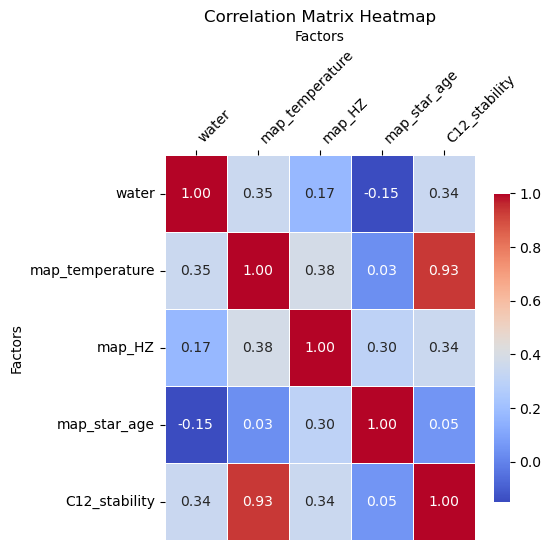

In [48]:
# CORRELATION ANALYSIS BETWEEN SUB-INDICES
selected_columns = ['water', 'map_temperature', 'map_HZ', 'map_star_age', 'C12_stability']
data_cor = data[selected_columns]

numeric_data_cor = data_cor.select_dtypes(include=[np.number])

correlation_matrix = numeric_data_cor.corr()

def calculate_p_value(r,n):
    df = n - 2
    t_squared = r**2 * (df/(1-r**2))
    p_value = betainc(0.5 * df, 0.5, df/(df + t_squared))
    return p_value


p_values = pd.DataFrame(np.zeros((numeric_data_cor.shape[1], numeric_data_cor.shape[1])), columns=numeric_data_cor.columns, index=numeric_data_cor.columns)

for col1 in numeric_data_cor.columns:
    for col2 in numeric_data_cor.columns:
        if col1 != col2:
            # Calculate Pearson correlation
            r = correlation_matrix.loc[col1, col2]
            # Number of observations
            n = numeric_data_cor.shape[0]
            # Calculate p-value
            p_val = calculate_p_value(r, n)
            p_values.loc[col1, col2] = p_val
        else:
            p_values.loc[col1, col2] = np.nan  # or 1, since a variable is perfectly correlated with itself


print(p_values)
plt.figure(figsize=(5, 5))  # Set the size of the plot
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})
heatmap.xaxis.set_ticks_position('top')
heatmap.xaxis.set_label_position('top')  # Move the x-axis label to the top
plt.xticks(rotation=45, ha='left') 

# Add title and labels
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Factors')
plt.ylabel('Factors')

# Display the plot
plt.show()

In [49]:
# OBTAIN THE INTERACTION WEIGHTS FROM THE CORRELATION DATA
interaction_weights = []

for index, (column_name, column_data) in enumerate(correlation_matrix.items()):
    column_list = column_data.tolist()

    threshold = 0.75

    # filter the column
    column_filtered = [0 if abs(x) < threshold or abs(x) == 1 else x for x in column_list]

    # obtain the interaction weights
    non_zero_count = 0
    non_zero_sum = 0

    for value in column_filtered:
        if value != 0:
            non_zero_count += 1
            non_zero_sum += value

    interaction_weight = 1
    if (non_zero_count != 0):
        interaction_weight = non_zero_sum/non_zero_count

    interaction_weight_processed = 1
    match interaction_weight:
        case interaction_weight if 0.75 <= interaction_weight < 0.85:
            interaction_weight_processed = 0.95 # lose 5%
        case interaction_weight if 0.85 <= interaction_weight < 0.95:
            interaction_weight_processed = 0.90 # lose 10%
        case interaction_weight if 0.95 <= interaction_weight < 1:
            interaction_weight_processed = 0.85 # lose 15% 

    # record the interaction weight
    interaction_weights.append(interaction_weight_processed)

# display the interaction weights
print(f"Interaction Weights: {interaction_weights}")


Interaction Weights: [1, 0.9, 1, 1, 0.9]


## Section 4: HUI - POHUI with Interactions

In [50]:
# CALCULATE HUI
def hui(weights, interactions, *values):
    weights_with_interactions = [weight * interaction for weight, interaction in zip(weights, interactions)]
    weighted_values = [processed_weight * value for processed_weight, value in zip(weights_with_interactions, values)]
    return sum(weighted_values)

data['HUI'] = data.apply(lambda row: hui( normalized_weights.values, interaction_weights, row['water'], row['map_temperature'], row['map_HZ'], row['map_star_age'], row['C12_stability']), axis = 1)

# DISPLAY HUI
def print_pretty(planet, hui, pohui):
    print(f'Planet -> {planet}, HUI -> {hui}, POHUI -> {pohui}')

for index, row in data.iterrows():
    print_pretty(row['planet'], row['HUI'], row['POHUI'])

Planet -> 1RXS 1609 b, HUI -> 0.0796592116646287, POHUI -> 0.07453990603933884
Planet -> 24 LMi b, HUI -> 0.1216020841464878, POHUI -> 0.14798965158078287
Planet -> 2MASS J1315-2649 b, HUI -> 0.2628881362456337, POHUI -> 0.21359877275667874
Planet -> 54 Psc c, HUI -> 0.08433110262277423, POHUI -> 0.08105893267895495
Planet -> AF Lep b, HUI -> 0.09987884352481323, POHUI -> 0.1010974511391455
Planet -> AU Mic b, HUI -> 0.09888276377692144, POHUI -> 0.11655687507476072
Planet -> AU Mic c, HUI -> 0.1419028099988827, POHUI -> 0.17532171739782448
Planet -> BD+20 594 b, HUI -> 0.19903429049100457, POHUI -> 0.2516088055503057
Planet -> BD+60 1417 b, HUI -> 0.07865794416899462, POHUI -> 0.07542935357478914
Planet -> beta Pic c, HUI -> 0.13277333831855018, POHUI -> 0.17498686352559584
Planet -> CFHTWIR-Oph 98 b, HUI -> 0.08267688977392525, POHUI -> 0.07829109215223125
Planet -> COCONUTS-2 b, HUI -> 0.11719455999712904, POHUI -> 0.13785449090018587
Planet -> CoRoT-22 b, HUI -> 0.09920959490826167

## Section 5: Analysis of Results

### Subsection 5.1: ESI Computation

In [51]:
# CALCULATION OF NECESSARY PARAMETERS
def density(mass, radius):
    volume = (4/3)*np.pi*(radius)**3
    density = mass/volume
    return density /1000

data['density'] = data.apply(lambda row: density(row['planet_mass_kg'], row['planet_radius_m']), axis = 1)

In [52]:
# CALCULATION OF ESI SUB-INDICES
data['ESI_r'] = data['planet_radius_m'] / 6.378137e+06
data['ESI_d'] = data['density'] / 5.493118
data['ESI_ev'] = data['escape_velocity'] / 11184.106164
data['ESI_t'] = data['temp_calculated_K'] 

In [53]:
# CALCULATION OF ESI 
def ESI(temperature, density, escape_velocity, radius):
    esi_T = (1- abs(((temperature - 288)/ (temperature + 288)) ))
    esi_D = (1- abs(((density - 1 )/ (density + 1 )) ))
    esi_EV = (1- abs(((escape_velocity - 1 )/ (escape_velocity + 1  )) ))
    esi_R = (1- abs(((radius - 1  )/ (radius + 1 )) ))

    ESI_s = ((esi_EV**0.7)*(esi_T**5.58))**0.5
    ESI_I = ((esi_D**1.07 )* (esi_R**0.57))**0.5

    ESI = (ESI_s  * ESI_I)**0.5

    return ESI

data['ESI'] = data.apply(lambda row: ESI(row['ESI_t'], row['ESI_d'], row['ESI_ev'], row['ESI_r']), axis = 1)

### Subsection 5.2: PHI Computation

In [54]:
# CALCULATION OF NECESARY PARAMETERS
def adj_AU(L_star, distance_AU):
    adj = np.sqrt(L_star/1)*distance_AU
    return adj

data['star_distance_AU_adj'] = data.apply(lambda row: adj_AU(row['Luminosity_Lsun'] , row['star_distance_AU']), axis = 1)

In [55]:
# CALCULATION OF PHI SUB-INDICES
def PHI_s(density):
    if density >= 3:
        value = 1
    elif 1 <= density < 3:
        value = 0.5
    else:
        value = 0

    return value

data['PHI_s'] = data.apply(lambda row: PHI_s(row['density']), axis = 1)

def PHI_e_l(adj_AU):
    if adj_AU <= 2.5:
        value = 2
    elif 2.5 < adj_AU < 10:
        value = 1
    else:
        value = 0

    return value

data['PHI_e_l'] = data.apply(lambda row: PHI_e_l(row['star_distance_AU_adj']), axis = 1)

def PHI_e_t(temp_K):
    if 200 <= temp_K <= 400:
        value = 1
    else:
        value = 0

    return value
  
data['PHI_e_t'] = data.apply(lambda row: PHI_e_t(row['temp_calculated_K']), axis = 1)
data['PHI_e'] = (data['PHI_e_l'] + data['PHI_e_t']) / 3

def PHI_c(C12):
    if C12 >= 0.75:
        value = 2
    elif 0.1 <= C12 < 0.75:
        value = 1
    else:
        value = 0
    return value

data['PHI_c'] = data.apply(lambda row: PHI_c(row['C12_stability']), axis = 1)
data['PHI_c'] = data['PHI_c'] / 2

def PHI_l(water):
    if water >= 0.5:
        value = 2
    elif 0.1 <= water < 0.5:
        value = 1
    else:
        value = 0
    return value

data['PHI_l'] = data.apply(lambda row: PHI_l(row['water']), axis = 1)
data['PHI_l'] = data['PHI_l'] / 2

In [56]:
# CALCULATION OF PHI
def PHI(S, E, C, L):

    if S == 0:
        S = 0.00001
    else:
        S = S

    if E == 0:
        E = 0.00001
    else:
        E = E

    if C == 0:
        C = 0.00001
    else:
        C = C
    
    if L == 0:
        L = 0.00001
    else:
        L = L
    phi = (S*E*C*L)**0.25
    return phi

data['PHI'] = data.apply(lambda row: PHI(row['PHI_s'], row['PHI_e'], row['PHI_c'], row['PHI_l']), axis = 1)

### Subsection 5.3: Saving Data and Displaying Results

In [57]:
# SAVING DATA
data.to_csv('../Data/large_validation.csv', index=False)

In [58]:
# DISPLAYING RESULTS
def display_results(planet, huiu_slojniy, PHI, ESI):
    print(f'Planet -> {planet}, HUI -> {huiu_slojniy}, PHI -> {PHI}, ESI -> {ESI}')

for index, row in data.iterrows():
    display_results(row['planet'], row['HUI'],row['PHI'], row['ESI'])

Planet -> 1RXS 1609 b, HUI -> 0.0796592116646287, PHI -> 0.0001778279410038923, ESI -> 0.07753127123414183
Planet -> 24 LMi b, HUI -> 0.1216020841464878, PHI -> 0.6389431042462724, ESI -> 0.5693349118310893
Planet -> 2MASS J1315-2649 b, HUI -> 0.2628881362456337, PHI -> 0.0028574404296987997, ESI -> 0.15780707057289833
Planet -> 54 Psc c, HUI -> 0.08433110262277423, PHI -> 0.0001778279410038923, ESI -> 0.09627869285596857
Planet -> AF Lep b, HUI -> 0.09987884352481323, PHI -> 0.00223606797749979, ESI -> 0.07583888174716327
Planet -> AU Mic b, HUI -> 0.09888276377692144, PHI -> 0.03593041119630842, ESI -> 0.3512058881928355
Planet -> AU Mic c, HUI -> 0.1419028099988827, PHI -> 0.6389431042462724, ESI -> 0.5724535684584171
Planet -> BD+20 594 b, HUI -> 0.19903429049100457, PHI -> 0.7071067811865476, ESI -> 0.6324130879891003
Planet -> BD+60 1417 b, HUI -> 0.07865794416899462, PHI -> 0.0001778279410038923, ESI -> 0.11467229971148878
Planet -> beta Pic c, HUI -> 0.13277333831855018, PHI ->